# UCI Dataset: Log-Linear Model v.s. Autoencoder

In [1]:
import os
os.environ["PYTHONWARNINGS"] = "ignore"

import warnings
warnings.filterwarnings('ignore')

import sys
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), os.pardir)))

import random

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, Subset

from sklearn.neighbors import KernelDensity

from tqdm import tqdm

import numpy as np
import cupy as cp
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder
from ucimlrepo import fetch_ucirepo

from joblib import Parallel, delayed

import ld
from utlis import vectorize_tensor, reconstruct_tensor

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Setup

### General

In [2]:
def set_random_seed(seed):
    random.seed(seed)
    np.random.seed(seed)

    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)

    cp.random.seed(seed)

    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


set_random_seed(42)
k = 5
bandwidth = 0.1
bandwidth_AE = 0.1
eps = np.asarray(1.0e-5)

### Dataset

In [3]:
UCI_id = 59 #
test_size = 0.2

In [4]:
UCI_dataset = fetch_ucirepo(id=UCI_id)

X = np.array(UCI_dataset.data.features)
Y = np.array(LabelEncoder().fit_transform(UCI_dataset.data.targets))

# Check whether features are all positive
print(X.min(), X.max())

if X.min() < 0:
    raise ValueError("Features are not all positive")


# Print the shape of features and labels
print("Shape of features:", X.shape)
print("Shape of labels:", Y.shape)

# Find unique labels
unique_labels = np.unique(Y)
print("Unique labels:", unique_labels)

# Create an array of indices
indices = np.arange(len(Y))
np.random.shuffle(indices)

# Use the shuffled indices to randomly select data for training and testing
n_train = int(len(Y) * (1 - test_size))
X_train, Y_train = X[indices[:n_train]], Y[indices[:n_train]]
X_test, Y_test = X[indices[n_train:]], Y[indices[n_train:]]

print("Shape of features:", X_train.shape)

X_train_class = []
Y_train_class = []
for i in unique_labels:
    X_train_class.append(X_train[np.isin(Y_train, i).flatten()])
    Y_train_class.append(Y_train[np.isin(Y_train, i).flatten()])

0 15
Shape of features: (20000, 16)
Shape of labels: (20000,)
Unique labels: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25]
Shape of features: (16000, 16)


In [8]:
# Feature dimension
D = X_train.shape[1]
S = (2, 2, 2, 2)
print("Tensor Structure of the Feature:", S)

if np.prod(S) != D:
    raise ValueError("The product of the tensor structure is not equal to the feature dimension")

# 20% of the data of the training set
num_new_samples = int((1 - test_size) * len(Y_train) * 0.2 // len(unique_labels))
print("Number of new samples per class:", num_new_samples)

Tensor Structure of the Feature: (2, 2, 2, 2)
Number of new samples per class: 98


In [6]:
# Define a custom Dataset class
class CustomDataset(Dataset):
    def __init__(self, data, labels, transform=None):
        """
        Args:
            data (numpy array): NumPy array of shape (num, 28*28)
            labels (numpy array): Corresponding labels for each image
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.data = data
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # Get the vector and label for a given index
        vector = self.data[idx].astype(np.float32)  # No reshaping, as data is general vector signal
        label = self.labels[idx]

        if self.transform:
            vector = self.transform(vector)

        return vector, label

train_data_original = np.array(X_train)
labels = Y_train
custom_train_dataset = CustomDataset(train_data_original, labels)
train_loader_original = DataLoader(dataset=custom_train_dataset, batch_size=16, shuffle=True)

## Data Augmentation with Log-LInear Model

### Legendre Decomposition (Many-Body Approximation)

In [7]:
B_LD = ld.default_B(S, 2, cp.get_array_module(X_train[0]))

print(B_LD.shape)

scaleX_class = []
theta_class = []

def LD_helper(i, class_):
    _, _, scaleX, _, theta = ld.LD(X_train_class[class_][i].reshape(*S), B=B_LD, verbose=False, n_iter=1000, lr=1e-1)
    return (scaleX, theta)

results = Parallel(n_jobs=30)(delayed(LD_helper)(i, class_) for class_ in unique_labels for i in range(len(X_train_class[class_])))

for class_ in unique_labels:
    scaleX_list = []
    theta_list = []

    for i in range(len(X_train_class[class_])):
        result = results[i + class_ * len(X_train_class[class_])]

        scaleX_list.append(result[0])
        theta_list.append(result[1])

    scaleX_class.append(scaleX_list)
    theta_class.append(theta_list)

(22, 3)


ValueError: cannot reshape array of size 16 into shape (2,3,5)

#### Fitting and Sampling

In [8]:
sampled_theta_class = []

for class_ in unique_labels:
    reduced_theta = vectorize_tensor(np.array(theta_class[class_]), B_LD)

    # Fit a KDE to the theta values
    kde = KernelDensity(kernel='gaussian', bandwidth=bandwidth).fit(reduced_theta)
    # Sample new data from the KDE
    sampled_reduced_theta = kde.sample(n_samples=num_new_samples)

    sampled_theta = reconstruct_tensor(sampled_reduced_theta, (num_new_samples, *S), B_LD)

    sampled_theta_class.append(sampled_theta)

#### Construct Submanifold

In [9]:
# Construct the constrained coordinates
B_BP = ld.default_B(S, 1, cp.get_array_module(X_train[0]))
# B_BP = B_LD

print(B_BP.shape)

# Compute every datapoint's eta_hat (served as the linear constraints)
eta_hat_class = []

for class_ in unique_labels:
    eta_hat_list = []
    for i in range(X_train_class[class_].shape[0]):
        xp = cp.get_array_module(X_train_class[class_][i])
        P = (X_train_class[class_][i].reshape(*S) + eps) / scaleX_class[class_][i]
        eta_hat = ld.get_eta(P, len(S), xp)
        eta_hat_list.append(eta_hat)
    eta_hat_list = cp.asarray(eta_hat_list)

    eta_hat_class.append(eta_hat_list)

(9, 4)


#### Backward Projection

In [10]:
def BP_helper(i, class_):
    N = ld.kNN(sampled_theta_class[class_][i], np.array(theta_class[class_]), k=k)
    avg_scale = np.mean(np.array(scaleX_class[class_])[N])
    avg_eta_hat = np.mean(eta_hat_class[class_][N], axis=0)

    _, _, P, theta = ld.BP(sampled_theta_class[class_][i], [(X_train_class[class_][j].reshape(*S) + eps) / scaleX_class[class_][j] for j in N], avg_eta_hat, avg_scale, B=B_BP, verbose=False, n_iter=1000, lr=5e-2, exit_abs=True)
    X_recons_ = P.reshape(-1)
    return (theta, X_recons_)

results = Parallel(n_jobs=30)(delayed(BP_helper)(i, class_) for i in range(num_new_samples) for class_ in unique_labels)

sampled_theta_BP_class = []
X_recons_class = []

for class_ in unique_labels:
    sampled_theta_BP = []
    sampled_X_recons = []
    X_recons_list = []
    for i in range(num_new_samples):
        result = results[i + num_new_samples * class_]

        sampled_theta_BP.append(result[0])
        sampled_X_recons.append(result[1])

    sampled_theta_BP_class.append(np.array(sampled_theta_BP))
    X_recons_class.append(np.array(sampled_X_recons))

### Store Augmented Data

In [11]:
augmented_data_LD = []

for class_ in unique_labels:
    for i in range(num_new_samples):
        augmented_data_LD.append(X_recons_class[class_][i])

train_data_LD = np.array(augmented_data_LD)
labels = np.repeat(unique_labels, num_new_samples)
custom_train_dataset = CustomDataset(train_data_LD, labels)
train_loader_LD = DataLoader(dataset=custom_train_dataset, batch_size=16, shuffle=True)

## Data Augmentation with Autoencoder

In [12]:
class Encoder(nn.Module):
    def __init__(self, input_size=D, hidden_size=D//4, z_dim=B_LD.shape[0]):
        super().__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        # self.fc2 = nn.Linear(hidden_size , hidden_size2)
        self.fc3 = nn.Linear(hidden_size, z_dim)
        self.relu = nn.ReLU()
    def forward(self , x):
        x = self.relu(self.fc1(x))
        # x = self.relu(self.fc2(x))
        x = self.fc3(x)
        return x

class Decoder(nn.Module):
    def __init__(self, output_size=D, hidden_size=D//4, z_dim=B_LD.shape[0]):
        super().__init__()
        self.fc1 = nn.Linear(z_dim , hidden_size)
        # self.fc2 = nn.Linear(hidden_size , hidden_size)
        self.fc3 = nn.Linear(hidden_size, output_size)
        self.relu = nn.ReLU()
    def forward(self , x):
        x = self.relu(self.fc1(x))
        # x = self.relu(self.fc2(x))
        x = torch.sigmoid(self.fc3(x))
        return x

In [13]:
enc = Encoder().to(device)
dec = Decoder().to(device)
loss_fn = nn.MSELoss()
optimizer_enc = torch.optim.Adam(enc.parameters())
optimizer_dec = torch.optim.Adam(dec.parameters())

100%|██████████| 100/100 [02:08<00:00,  1.29s/it]


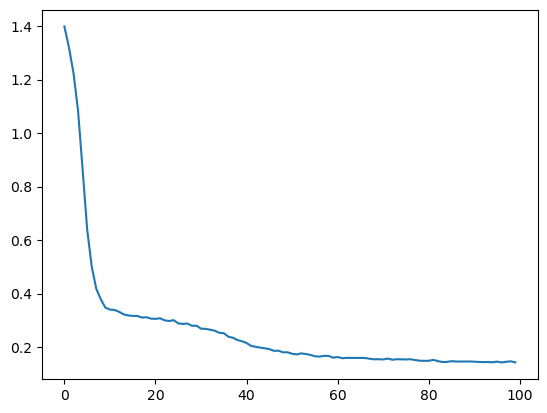

In [14]:
train_loss = []
num_epochs = 100

for epoch in tqdm(range(num_epochs)):
    train_epoch_loss = 0
    for (x , _) in train_loader_original:
        x = x.to(device)
        #100 , 1 , 28 , 28 ---> (100 , 28*28)
        x = x.flatten(1)
        latents = enc(x)
        output = dec(latents)
        loss = loss_fn(output , x)
        train_epoch_loss += loss.cpu().detach().numpy()
        optimizer_enc.zero_grad()
        optimizer_dec.zero_grad()
        loss.backward()
        optimizer_enc.step()
        optimizer_dec.step()
    train_loss.append(train_epoch_loss)
plt.plot(train_loss)

In [15]:
representation = None
all_labels = []

with torch.no_grad():
    for (xs , labels) in train_loader_original:
        xs = xs.to(device)
        xs = xs.flatten(1)
        all_labels.extend(list(labels.numpy()))
        latents = enc(xs)
        if representation is None:
            representation = latents.cpu()
        else:
            representation = torch.vstack([representation , latents.cpu()])

all_labels = np.array(all_labels)
representation = representation.numpy()

In [16]:
sampled_AE_class = []

for class_ in unique_labels:
    sampled_AE_list = []

    rep = representation[np.argwhere(all_labels == class_)].squeeze()
    # Fit a KDE to the theta values
    kde = KernelDensity(kernel='gaussian', bandwidth=bandwidth_AE).fit(rep)

    # Sample new data from the KDE
    sampled_rep = kde.sample(n_samples=num_new_samples)
    for i in range(num_new_samples):
        pred = dec(torch.Tensor(sampled_rep[i])[None , ...].to(device)).cpu().detach().numpy()
        sampled_AE_list.append(pred)

    sampled_AE_class.append(sampled_AE_list)

### Store Augmented Data

In [17]:
augmented_data_AE = []

for class_ in unique_labels:
    for i in range(num_new_samples):
        augmented_data_AE.append(sampled_AE_class[class_][i].flatten())

train_data_AE = np.array(augmented_data_AE)
labels = np.repeat(unique_labels, num_new_samples)

custom_train_dataset = CustomDataset(train_data_AE, labels)
train_loader_AE = DataLoader(dataset=custom_train_dataset, batch_size=16, shuffle=True)

## Classification Performance

### Logistic Regression Model

In [18]:
class LogisticRegressionModel(nn.Module):
    def __init__(self, input_size, num_classes=10):
        super(LogisticRegressionModel, self).__init__()
        self.linear = nn.Linear(input_size, num_classes)  # Linear layer for general input size

    def forward(self, x):
        out = self.linear(x)   # Apply linear transformation
        return out

# Function to train the model
def train_model(model, train_loader, criterion, optimizer, num_epochs=5, device='cpu'):
    model.to(device)
    for epoch in range(num_epochs):
        model.train()  # Set model to training mode
        running_loss = 0.0

        for vectors, labels in train_loader:
            vectors, labels = vectors.to(device), labels.to(device)

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(vectors)
            loss = criterion(outputs, labels)

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}")

# Function to test the model
def test_model(model, test_loader, device='cpu'):
    model.eval()  # Set model to evaluation mode
    correct = 0
    total = 0

    with torch.no_grad():
        for vectors, labels in test_loader:
            vectors, labels = vectors.to(device), labels.to(device)
            outputs = model(vectors)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    return accuracy

# Main function to run training and testing on a dataset
def bootstrapping(train_loader, test_dataset, input_size, num_classes=10, num_epochs=5, learning_rate=0.05, device='cpu'):
    # Initialize model, loss function, and optimizer
    model = LogisticRegressionModel(input_size=input_size, num_classes=num_classes).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=learning_rate)

    # Train the model
    train_model(model, train_loader, criterion, optimizer, num_epochs=num_epochs, device=device)

    # Number of bootstrap resamples
    n_bootstrap = 20
    accuracies = []

    # Perform bootstrapping
    for i in range(n_bootstrap):
        # Randomly sample 500 examples from the dataset with replacement
        indices = torch.randint(len(test_dataset), size=(50,))
        bootstrap_subset = Subset(test_dataset, indices)
        bootstrap_loader = DataLoader(dataset=bootstrap_subset, batch_size=50, shuffle=False)

        # Calculate accuracy on the bootstrap sample
        accuracy = test_model(model, bootstrap_loader, device=device)
        accuracies.append(accuracy)

    # Compute the mean and standard deviation of accuracy
    mean_accuracy = np.mean(accuracies)
    std_accuracy = np.std(accuracies)

    # Calculate 95% confidence interval (mean ± 1.96 * standard deviation)
    confidence_interval = (mean_accuracy - 1.96 * std_accuracy, mean_accuracy + 1.96 * std_accuracy)

    print(f"Mean accuracy: {mean_accuracy:.2f}%")
    print(f"95% confidence interval: ({confidence_interval[0]:.2f}%, {confidence_interval[1]:.2f}%)")

In [19]:
test_dataset = CustomDataset(X_test, Y_test)

### Original Dataset

In [20]:
bootstrapping(train_loader_original, test_dataset, input_size=X_train.shape[1], num_classes=len(unique_labels), num_epochs=20, learning_rate=0.05, device=device)

Epoch [1/20], Loss: 0.6759
Epoch [2/20], Loss: 0.6686
Epoch [3/20], Loss: 0.6592
Epoch [4/20], Loss: 0.6509
Epoch [5/20], Loss: 0.6434
Epoch [6/20], Loss: 0.6321
Epoch [7/20], Loss: 0.6320
Epoch [8/20], Loss: 0.6243
Epoch [9/20], Loss: 0.6262
Epoch [10/20], Loss: 0.6175
Epoch [11/20], Loss: 0.6085
Epoch [12/20], Loss: 0.5931
Epoch [13/20], Loss: 0.5953
Epoch [14/20], Loss: 0.5809
Epoch [15/20], Loss: 0.5854
Epoch [16/20], Loss: 0.5857
Epoch [17/20], Loss: 0.5674
Epoch [18/20], Loss: 0.5714
Epoch [19/20], Loss: 0.5621


Epoch [20/20], Loss: 0.5660
Mean accuracy: 60.10%
95% confidence interval: (48.64%, 71.56%)


### Augmented Dataset

#### Log-Linear Model

In [21]:
bootstrapping(train_loader_LD, test_dataset, input_size=X_train.shape[1], num_classes=len(unique_labels), num_epochs=20, learning_rate=0.05, device=device)

Epoch [1/20], Loss: 0.7494
Epoch [2/20], Loss: 0.7266
Epoch [3/20], Loss: 0.7268
Epoch [4/20], Loss: 0.6960
Epoch [5/20], Loss: 0.7177
Epoch [6/20], Loss: 0.6936
Epoch [7/20], Loss: 0.6825
Epoch [8/20], Loss: 0.6707
Epoch [9/20], Loss: 0.6684
Epoch [10/20], Loss: 0.6709
Epoch [11/20], Loss: 0.6781
Epoch [12/20], Loss: 0.6583
Epoch [13/20], Loss: 0.6617
Epoch [14/20], Loss: 0.6702
Epoch [15/20], Loss: 0.6722
Epoch [16/20], Loss: 0.6615
Epoch [17/20], Loss: 0.6517
Epoch [18/20], Loss: 0.6602
Epoch [19/20], Loss: 0.6640
Epoch [20/20], Loss: 0.6454
Mean accuracy: 54.20%
95% confidence interval: (39.38%, 69.02%)


#### Autoencoder

In [22]:
bootstrapping(train_loader_AE, test_dataset, input_size=X_train.shape[1], num_classes=len(unique_labels), num_epochs=20, learning_rate=0.05, device=device)

Epoch [1/20], Loss: 0.6970
Epoch [2/20], Loss: 0.6789
Epoch [3/20], Loss: 0.6831
Epoch [4/20], Loss: 0.6809
Epoch [5/20], Loss: 0.6740
Epoch [6/20], Loss: 0.6733
Epoch [7/20], Loss: 0.6672
Epoch [8/20], Loss: 0.6630
Epoch [9/20], Loss: 0.6698
Epoch [10/20], Loss: 0.6705
Epoch [11/20], Loss: 0.6678
Epoch [12/20], Loss: 0.6652
Epoch [13/20], Loss: 0.6626
Epoch [14/20], Loss: 0.6551
Epoch [15/20], Loss: 0.6822
Epoch [16/20], Loss: 0.6744
Epoch [17/20], Loss: 0.6714
Epoch [18/20], Loss: 0.6594
Epoch [19/20], Loss: 0.6455
Epoch [20/20], Loss: 0.6650
Mean accuracy: 66.30%
95% confidence interval: (55.54%, 77.06%)


### Original and Augmented Dataset

#### Log-Linear Model

In [23]:
train_data = np.vstack([train_data_original, train_data_LD])
labels = np.hstack([Y_train, np.repeat(unique_labels, num_new_samples)])
custom_train_dataset = CustomDataset(train_data, labels)

train_loader = DataLoader(dataset=custom_train_dataset, batch_size=16, shuffle=True)

bootstrapping(train_loader, test_dataset, input_size=X_train.shape[1], num_classes=len(unique_labels), num_epochs=20, learning_rate=0.05, device=device)

Epoch [1/20], Loss: 0.6889
Epoch [2/20], Loss: 0.6765
Epoch [3/20], Loss: 0.6657


Epoch [4/20], Loss: 0.6567
Epoch [5/20], Loss: 0.6519
Epoch [6/20], Loss: 0.6427
Epoch [7/20], Loss: 0.6367
Epoch [8/20], Loss: 0.6308
Epoch [9/20], Loss: 0.6215
Epoch [10/20], Loss: 0.6239
Epoch [11/20], Loss: 0.6157
Epoch [12/20], Loss: 0.6134
Epoch [13/20], Loss: 0.6059
Epoch [14/20], Loss: 0.6015
Epoch [15/20], Loss: 0.5962
Epoch [16/20], Loss: 0.5918
Epoch [17/20], Loss: 0.5898
Epoch [18/20], Loss: 0.5849
Epoch [19/20], Loss: 0.5821
Epoch [20/20], Loss: 0.5780
Mean accuracy: 77.40%
95% confidence interval: (64.63%, 90.17%)


#### Autoencoder

In [24]:
train_data = np.vstack([train_data_original, train_data_AE])
labels = np.hstack([Y_train, np.repeat(unique_labels, num_new_samples)])
custom_train_dataset = CustomDataset(train_data, labels)

train_loader = DataLoader(dataset=custom_train_dataset, batch_size=16, shuffle=True)

bootstrapping(train_loader, test_dataset, input_size=X_train.shape[1], num_classes=len(unique_labels), num_epochs=20, learning_rate=0.05, device=device)

Epoch [1/20], Loss: 0.7129
Epoch [2/20], Loss: 0.6959
Epoch [3/20], Loss: 0.6933
Epoch [4/20], Loss: 0.6717
Epoch [5/20], Loss: 0.6664
Epoch [6/20], Loss: 0.6572
Epoch [7/20], Loss: 0.6507
Epoch [8/20], Loss: 0.6472
Epoch [9/20], Loss: 0.6312
Epoch [10/20], Loss: 0.6285
Epoch [11/20], Loss: 0.6225
Epoch [12/20], Loss: 0.6162
Epoch [13/20], Loss: 0.6097
Epoch [14/20], Loss: 0.6041
Epoch [15/20], Loss: 0.6010
Epoch [16/20], Loss: 0.5976
Epoch [17/20], Loss: 0.5905
Epoch [18/20], Loss: 0.5888
Epoch [19/20], Loss: 0.5817
Epoch [20/20], Loss: 0.5804
Mean accuracy: 64.80%
95% confidence interval: (51.95%, 77.65%)
